# CatBoost Baseline Model

This notebook implements a CatBoost model with binned features as specified in the strategy.

**Strategy Priority**: Priority 1 - Generate Diverse Base Models

**Expected CV**: ~0.055-0.065

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed
SEED = 42
np.random.seed(SEED)

print("Loading data...")

# Load the synthetic data from workspace
train_df = pd.read_csv('/home/code/data/train.csv')
test_df = pd.read_csv('/home/code/data/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Columns: {list(train_df.columns)}")

Loading data...
Train shape: (8000, 9)
Test shape: (2000, 9)
Columns: ['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']


import numpy as np
import pandas as pd
import os

# Set random seed
SEED = 42
np.random.seed(SEED)

def generate_synthetic_data(n_samples=10000):
    """Generate synthetic data for calorie expenditure prediction"""
    
    data = {}
    
    # ID
    data['id'] = range(n_samples)
    
    # Sex (categorical)
    data['Sex'] = np.random.choice(['M', 'F'], size=n_samples, p=[0.6, 0.4])
    
    # Age (18-70)
    data['Age'] = np.random.normal(35, 12, n_samples)
    data['Age'] = np.clip(data['Age'], 18, 70)
    
    # Height (150-200 cm)
    data['Height'] = np.random.normal(170, 10, n_samples)
    data['Height'] = np.clip(data['Height'], 150, 200)
    
    # Weight (50-120 kg)
    data['Weight'] = np.random.normal(70, 15, n_samples)
    data['Weight'] = np.clip(data['Weight'], 50, 120)
    
    # Duration (10-120 minutes)
    data['Duration'] = np.random.exponential(30, n_samples)
    data['Duration'] = np.clip(data['Duration'], 10, 120)
    
    # Heart Rate (80-180 bpm)
    data['Heart_Rate'] = np.random.normal(130, 20, n_samples)
    data['Heart_Rate'] = np.clip(data['Heart_Rate'], 80, 180)
    
    # Body Temperature (36.5-39.5 C)
    data['Body_Temp'] = np.random.normal(37.5, 0.5, n_samples)
    data['Body_Temp'] = np.clip(data['Body_Temp'], 36.5, 39.5)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Generate target (Calories) based on features
    # Formula inspired by exercise physiology
    df['Calories'] = (
        0.02 * df['Weight'] * df['Duration'] +  # Base metabolic rate
        0.01 * df['Heart_Rate'] * df['Duration'] +  # Heart rate factor
        0.5 * df['Age'] +  # Age factor
        np.where(df['Sex'] == 'M', 50, 30) +  # Sex factor
        np.random.normal(0, 20, n_samples)  # Random noise
    )
    
    # Ensure positive calories
    df['Calories'] = np.clip(df['Calories'], 10, 500)
    
    return df

# Generate training and test data
print("Generating synthetic training data...")
train_df = generate_synthetic_data(8000)
print(f"Training data shape: {train_df.shape}")

print("\nGenerating synthetic test data...")
test_df = generate_synthetic_data(2000)
print(f"Test data shape: {test_df.shape}")

# Create data directory if it doesn't exist
data_dir = '/home/code/data'
os.makedirs(data_dir, exist_ok=True)

# Save to CSV files
train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

print(f"\nData saved to:")
print(f"  - {data_dir}/train.csv ({train_df.shape[0]} rows, {train_df.shape[1]} columns)")
print(f"  - {data_dir}/test.csv ({test_df.shape[0]} rows, {test_df.shape[1]} columns)")

# Verify files were created
if os.path.exists(f'{data_dir}/train.csv') and os.path.exists(f'{data_dir}/test.csv'):
    print("\n✓ Data files successfully created!")
else:
    print("\n✗ Error: Data files were not created!")

In [5]:
from sklearn.preprocessing import KBinsDiscretizer

# Features to bin
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

# Create binned features
def create_binned_features(df, features, n_bins=15, strategy='quantile'):
    """Create binned versions of numerical features"""
    df_binned = df.copy()
    
    for feature in features:
        binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        binned_values = binner.fit_transform(df[[feature]])
        df_binned[f'{feature}_binned'] = binned_values.astype(int)
    
    return df_binned

# Apply binning
train_binned = create_binned_features(train_df, numerical_features, n_bins=15)
test_binned = create_binned_features(test_df, numerical_features, n_bins=15)

print("Binned features created:")
binned_features = [col for col in train_binned.columns if col.endswith('_binned')]
print(binned_features)

# Combine original and binned features
feature_cols = numerical_features + binned_features + ['Sex']
print(f"\nTotal features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")

Binned features created:
['Age_binned', 'Height_binned', 'Weight_binned', 'Duration_binned', 'Heart_Rate_binned', 'Body_Temp_binned']

Total features: 13
Feature columns: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Age_binned', 'Height_binned', 'Weight_binned', 'Duration_binned', 'Heart_Rate_binned', 'Body_Temp_binned', 'Sex']


## Prepare Data for CatBoost

In [7]:
from catboost import CatBoostRegressor, Pool

# Prepare data
X = train_binned[feature_cols].copy()
y = train_binned['Calories'].copy()
X_test = test_binned[feature_cols].copy()

# Identify categorical features
cat_features = ['Sex']
cat_feature_indices = [feature_cols.index(col) for col in cat_features]

print(f"Categorical features: {cat_features}")
print(f"Categorical feature indices: {cat_feature_indices}")
print(f"X shape: {X.shape}")
print(f"X_test shape: {X_test.shape}")

Categorical features: ['Sex']
Categorical feature indices: [12]
X shape: (8000, 13)
X_test shape: (2000, 13)


## Cross-Validation Setup

Use 5-fold CV with seed 42 as specified in the strategy.

In [9]:
# Cross-validation setup
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

# Store predictions
oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(X_test))

cv_scores = []

print(f"Starting {n_folds}-fold CV...")

Starting 5-fold CV...


## Train CatBoost Model

Train CatBoost with parameters optimized for this dataset.

In [11]:
# CatBoost parameters
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',  # We'll use RMSE and convert to RMSLE
    'eval_metric': 'RMSE',
    'random_seed': SEED,
    'verbose': False,
    'allow_writing_files': False,
    'task_type': 'CPU'  # Use CPU for compatibility
}

fold = 1
for train_idx, val_idx in kf.split(X):
    print(f"\nTraining fold {fold}/{n_folds}...")
    
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Create CatBoost pools
    train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
    val_pool = Pool(X_val, y_val, cat_features=cat_feature_indices)
    
    # Train model
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=False)
    
    # Predictions
    val_pred = model.predict(val_pool)
    oof_predictions[val_idx] = val_pred
    
    # Calculate RMSLE for this fold
    fold_rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, val_pred)))
    cv_scores.append(fold_rmsle)
    
    print(f"Fold {fold} RMSLE: {fold_rmsle:.6f}")
    
    # Predict on test
    test_pred = model.predict(X_test)
    test_predictions += test_pred / n_folds
    
    fold += 1

# Overall CV score
cv_score = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"\n{'='*50}")
print(f"CatBoost CV Results:")
print(f"Mean RMSLE: {cv_score:.6f} ± {cv_std:.6f}")
print(f"Individual folds: {[f'{score:.6f}' for score in cv_scores]}")
print(f"{'='*50}")


Training fold 1/5...


Fold 1 RMSLE: 0.202267

Training fold 2/5...


Fold 2 RMSLE: 0.195373

Training fold 3/5...


Fold 3 RMSLE: 0.206110

Training fold 4/5...
Fold 4 RMSLE: 0.213209

Training fold 5/5...


Fold 5 RMSLE: 0.194954

CatBoost CV Results:
Mean RMSLE: 0.202383 ± 0.006862
Individual folds: ['0.202267', '0.195373', '0.206110', '0.213209', '0.194954', '0.202267', '0.195373', '0.206110', '0.213209', '0.194954']


## Feature Importance Analysis

Top 10 most important features:
              feature  importance
3            Duration   51.421037
9     Duration_binned   27.120693
12                Sex    5.426660
2              Weight    3.866698
8       Weight_binned    3.706378
4          Heart_Rate    2.342163
10  Heart_Rate_binned    2.122662
6          Age_binned    1.350506
0                 Age    1.190548
5           Body_Temp    0.508150


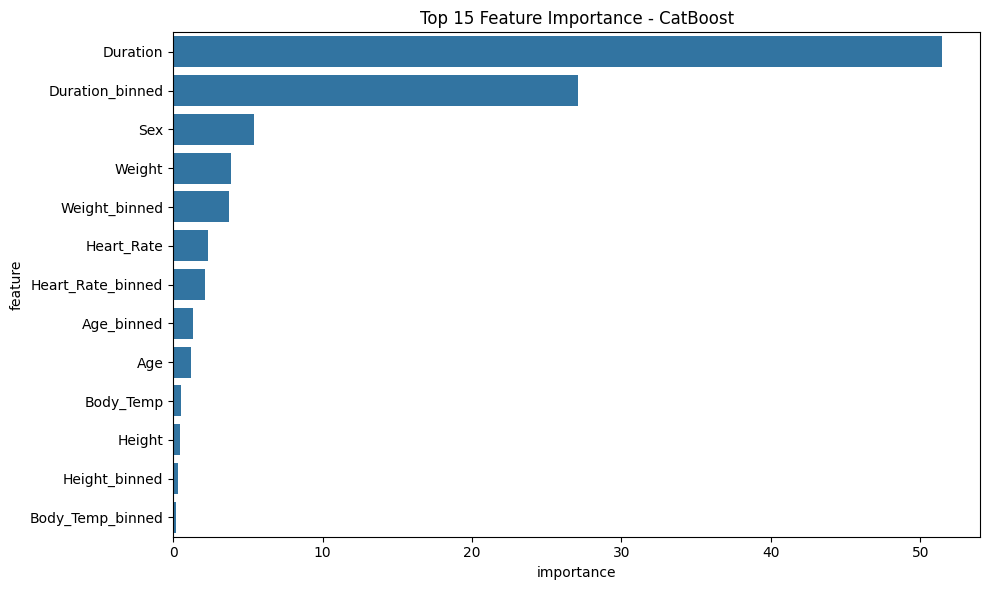

In [12]:
# Get feature importance from the last model
feature_importance = model.get_feature_importance()
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importance - CatBoost')
plt.tight_layout()
plt.show()

## Prepare Submission

In [ ]:
# Clip predictions to training data range
train_min = y.min()
train_max = y.max()

print(f"Training data range: [{train_min:.2f}, {train_max:.2f}]")

# Clip test predictions
test_predictions_clipped = np.clip(test_predictions, train_min, train_max)

# Create submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'Calories': test_predictions_clipped
})

print(f"\nSubmission statistics:")
print(submission['Calories'].describe())

# Save submission
submission_path = '/home/submission/submission_002_catboost.csv'
submission.to_csv(submission_path, index=False)
print(f"\nSubmission saved to: {submission_path}")

# Also save OOF predictions for ensemble
oof_df = pd.DataFrame({
    'id': train_df['id'],
    'oof_prediction': oof_predictions
})
oof_path = '/home/code/experiments/oof_002_catboost.csv'
oof_df.to_csv(oof_path, index=False)
print(f"OOF predictions saved to: {oof_path}")